In [1]:
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from scrapping.scrapping_tools import *

In [2]:
orateurs_datas = {}
not_found = []

In [ ]:
full_datas= []
for k in range(1,3):
    L = get_links_page(k)
    print("page = ", k )
    for c,i in enumerate(L):
        xml_l = get_xml(i)
        if(not xml_l):
            continue
        dt = extract_xml(xml_l, orateurs_datas, not_found)
        full_datas += dt
        #print("dt= ", dt)

page =  1


  0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA773443
paragraph p not parsed:  <nom>M. Éric Dupond-Moretti</nom>


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA205600
paragraph p not parsed:  <nom>Mme Florence Parly</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA759832
paragraph p not parsed:  <nom>Mme Agnès Pannier-Runacher</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA773441
paragraph p not parsed:  <nom>M. Jean Castex</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA773451
paragraph p not parsed:  <nom>M. Alain Griset</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA717161
paragraph p not parsed:  <nom>Mme Élisabeth Borne</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA717157
paragraph p not parsed:  <nom>M. Jean-Michel Blanquer</nom>


  0%|          | 0/371 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA758792
paragraph p not parsed:  <nom>Mme Roxana Maracineanu</nom>
Cannot parse the link:  https://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA643210
paragraph p not parsed:  <nom>M. Sébastien Lecornu</nom>


  0%|          | 0/214 [00:00<?, ?it/s]

In [8]:
D= merge_dict(orateurs_datas.values())
df = pd.DataFrame(D)
df

,name,group,circonscription
0,M. Richard Ferrand- Président de l'Assemblée n...,La République en Marche,Finistère (6e circonscription)
1,M. Philippe Gosselin,Les Républicains,Manche (1re circonscription)
2,M. Fabien Roussel,Gauche démocrate et républicaine,Nord (20e circonscription)
3,Mme Sonia Krimi,La République en Marche,Manche (4e circonscription)
4,M. Jean-Louis Bricout,Socialistes et apparentés,Aisne (3e circonscription)
...,...,...,...
315,Mme Marie Silin,La République en Marche,Paris (12e circonscription)
316,Mme Frédérique Tuffnell,Mouvement Démocrate (MoDem) et Démocrates appa...,Charente-Maritime (2e circonscription)
317,Mme Fadila Khattabi,La République en Marche,Côte-d'Or (3e circonscription)
318,M. Sébastien Nadot,Libertés et Territoires,Haute-Garonne (10e circonscription)


In [9]:
D= merge_dict(full_datas)
df = pd.DataFrame(D)
df

,name,group,circonscription,texte
0,M. Richard Ferrand- Président de l'Assemblée n...,La République en Marche,Finistère (6e circonscription),La parole est à M. Philippe Gosselin.
1,M. Philippe Gosselin,Les Républicains,Manche (1re circonscription),Ma question s’adresse à M. le Premier ministre...
2,M. Richard Ferrand- Président de l'Assemblée n...,La République en Marche,Finistère (6e circonscription),La parole est à Mme la ministre des armées. (V...
3,M. Richard Ferrand- Président de l'Assemblée n...,La République en Marche,Finistère (6e circonscription),La parole est à M. Fabien Roussel.
4,M. Fabien Roussel,Gauche démocrate et républicaine,Nord (20e circonscription),Le 21 septembre est la Journée internationale ...
...,...,...,...,...
5901,M. Bruno Studer,La République en Marche,Bas-Rhin (3e circonscription),M. le secrétaire d’État ayant présenté l’artic...
5902,M. Sylvain Waserman,Mouvement Démocrate (MoDem) et Démocrates appa...,Bas-Rhin (2e circonscription),La parole est à Mme Isabelle Santiago.
5903,Mme Isabelle Santiago,Socialistes et apparentés,Val-de-Marne (9e circonscription),"Puisque mon amendement no 430 va tomber, je so..."
5904,M. Sylvain Waserman,Mouvement Démocrate (MoDem) et Démocrates appa...,Bas-Rhin (2e circonscription),La parole est à Mme Perrine Goulet.


In [10]:
df_g = df.groupby("group").apply(lambda x: x.sum())["texte"].reset_index()

In [11]:
osef_words = ["président", "article", "banc", "français","loi", "texte", "groupe", "applaudissement", "monsieur", "ministre", "amendement", "question", "état", "gouvernement"]
def filter_text(text):
    nlp = spacy.load("fr_core_news_sm")
    nlp.max_length = 1e25
    doc = nlp(text)
    conserved_words = []
    for token in doc:
        if(token.pos_ == "NOUN" and not token.is_stop and token.is_alpha):
            if(token.lemma_ not in osef_words and token.text not in osef_words):
                conserved_words.append(token.lemma_)
    return conserved_words

In [12]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    

In [13]:
for group, texte in zip(df_g["group"], df_g["texte"]):
    corpus = filter_text(texte)
    freq = get_top_n_words(corpus, n = 25)
    print("========")
    print(f"group: {group} : ")
    for f in freq:
        print(f[0], " : ", f[1])
    print("========")


group: Agir ensemble : 
travail  :  65
projet  :  60
crise  :  54
ensemble  :  50
mesure  :  41
personne  :  39
finance  :  38
commission  :  34
droit  :  33
pays  :  31
collègue  :  31
vie  :  31
territoire  :  31
situation  :  30
santé  :  29
proposition  :  28
an  :  26
compte  :  26
protection  :  25
année  :  24
liberté  :  23
politique  :  23
enfant  :  22
assemblée  :  22
débat  :  21
group: Gauche démocrate et républicaine : 
enfant  :  99
mesure  :  82
travail  :  76
droit  :  75
crise  :  69
santé  :  63
projet  :  60
situation  :  48
urgence  :  47
politique  :  44
moyen  :  43
débat  :  41
lieu  :  40
année  :  38
vaccination  :  36
collègue  :  36
commission  :  36
violence  :  36
territoire  :  35
besoin  :  35
dépense  :  35
liberté  :  34
sujet  :  34
raison  :  34
part  :  32
group: La France insoumise : 
droit  :  156
mesure  :  141
an  :  138
enfant  :  129
personne  :  111
vaccination  :  98
cas  :  96
urgence  :  92
collègue  :  90
projet  :  87
pays  :  83
problèm

In [23]:
def count_term(text, term):
    c = 0
    for k in text:
        if( k.lower() == term.lower()):
            c = c + 1
    return c


In [28]:
displ = {
    "group":[], 
    "word":[],
    "number":[]
}
for group, texte in zip(df_g["group"], df_g["texte"]):
    print("group: ", group)
    f_text = filter_text(texte)
    print("Travail : ", count_term(f_text,"travail"))
    displ["word"].append("Travail")
    displ["group"].append(group)
    displ["number"].append(count_term(f_text,"travail"))
    print("Droit : ", count_term(f_text,"droit"))
    displ["word"].append("Droit")
    displ["group"].append(group)
    displ["number"].append(count_term(f_text,"droit"))


group:  Agir ensemble
Travail :  65
Droit :  33
group:  Gauche démocrate et républicaine
Travail :  76
Droit :  75
group:  La France insoumise
Travail :  68
Droit :  156
group:  La République en Marche
Travail :  373
Droit :  214
group:  Les Républicains
Travail :  85
Droit :  54
group:  Libertés et Territoires
Travail :  52
Droit :  61
group:  Mouvement Démocrate (MoDem) et Démocrates apparentés
Travail :  61
Droit :  41
group:  Mouvement Démocrate et apparentés
Travail :  2
Droit :  2
group:  Non inscrit
Travail :  26
Droit :  41
group:  Nouvelle Gauche
Travail :  10
Droit :  8
group:  Socialiste
Travail :  0
Droit :  2
group:  Socialistes et apparentés
Travail :  52
Droit :  46
group:  UDI et Indépendants
Travail :  15
Droit :  22
group:  UDI, Agir et Indépendants
Travail :  1
Droit :  0


In [32]:
df_g = pd.DataFrame(displ)

In [40]:
df_g["group"] = df_g["group"].replace("Mouvement Démocrate et apparentés", "MODEM")
df_g["group"] = df_g["group"].replace("Mouvement Démocrate (MoDem) et Démocrates apparentés", "MODEM")
df_g["group"] = df_g["group"].replace("La France insoumise", "LFI")
df_g["group"] = df_g["group"].replace("Agir ensemble", "AE")
df_g["group"] = df_g["group"].replace("La République en Marche", "LREM")
df_g["group"] = df_g["group"].replace("Les Républicains", "LR")
df_g["group"] = df_g["group"].replace("Libertés et Territoires", "LT")
df_g["group"] = df_g["group"].replace("Non inscrit", "NI")
df_g["group"] = df_g["group"].replace("Nouvelle Gauche", "NG")
df_g["group"] = df_g["group"].replace("Socialistes et apparentés", "SOC")
df_g["group"] = df_g["group"].replace("UDI et Indépendants", "UDI")
df_g["group"] = df_g["group"].replace("UDI, Agir et Indépendants", "UDI")

df_g["group"] = df_g["group"].replace("Socialiste", "SOC")


df_g["group"] = df_g["group"].replace("Gauche démocrate et républicaine", "GDR")


In [67]:
df_g = df_g.groupby(["group","word"]).sum().reset_index()
df_g

,group,word,number
0,AE,Droit,33
1,AE,Travail,65
2,GDR,Droit,75
3,GDR,Travail,77
4,LFI,Droit,156
5,LFI,Travail,68
6,LR,Droit,54
7,LR,Travail,85
8,LREM,Droit,214
9,LREM,Travail,373


In [71]:
s = df_g[df_g.group == "AE"]["number"].sum()
df_g[df_g.group == "AE"]["number"] = df_g[df_g.group == "AE"]["number"] / s

<ipython-input-71-1f1626bcb568>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g[df_g.group == "AE"]["number"] = df_g[df_g.group == "AE"]["number"] / s


In [73]:
df_g[df_g.group == "AE"]["number"]

0    33
1    65
Name: number, dtype: int64

In [44]:

import seaborn as sns
sns.set_theme(style="whitegrid")

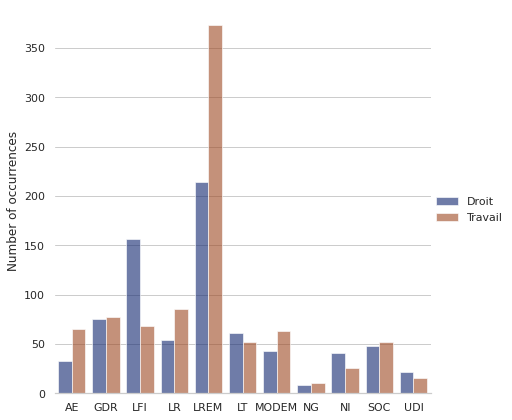

In [74]:
g = sns.catplot(
    data=df_g, kind="bar",
    x="group", y="number", hue="word",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Number of occurrences")
g.legend.set_title("")

In [79]:
fig = g.fig
fig.savefig('droit_travail.png', dpi=fig.dpi)